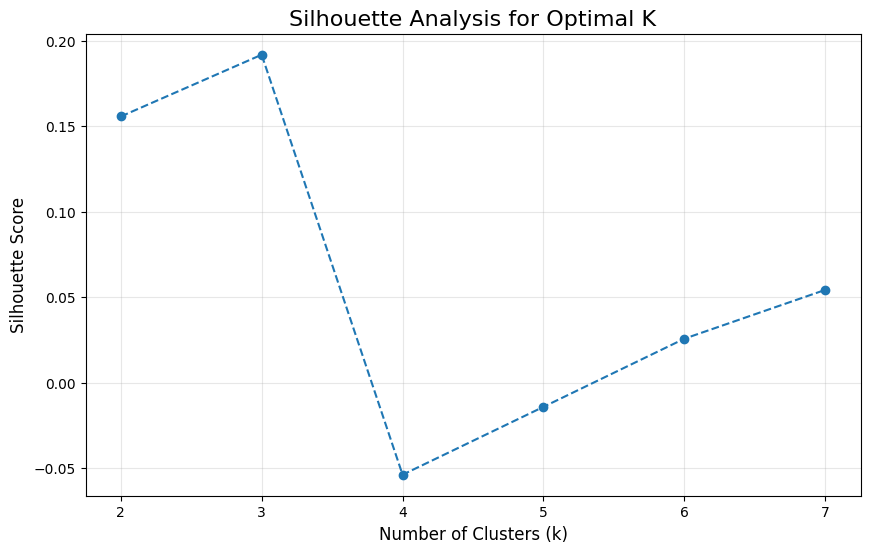

0.1918666


In [49]:
from sklearn.metrics import silhouette_score

# Step 4: Retrieve vectors from FAISS database
stored_vectors = vector_db.reconstruct_n(0, vector_db.ntotal)

# Step 5: Perform KMeans clustering with varying number of clusters
silhouette_scores = []
k_values = range(2, 8)  # Testing from 2 to 10 clusters

for k in k_values:
    kmeans = faiss.Kmeans(d=4096, k=k, niter=20, verbose=False)
    kmeans.train(stored_vectors)
    _, cluster_labels = kmeans.index.search(stored_vectors, 1)
    score = silhouette_score(stored_vectors, cluster_labels.flatten())
    silhouette_scores.append(score)

# Step 6: Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Analysis for Optimal K', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(k_values)
plt.grid(alpha=0.3)
plt.show()

print(max(silhouette_scores))

## Novo

In [3]:
import pandas as pd
import numpy as np
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re

In [49]:
data_path = r"..\data\reviews_processed_llm.json"

df = pd.read_json(data_path, encoding='utf-8')

In [50]:
columns = ['quantidade_premios', 'votos_review', 'avaliacao', 'horas_jogadas', 'data_publicacao', 'texto_processado',"recebeu_gratis"]

df = df[columns]

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6535 entries, 0 to 6534
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   quantidade_premios  6535 non-null   int64 
 1   votos_review        6535 non-null   object
 2   avaliacao           6535 non-null   object
 3   horas_jogadas       6535 non-null   object
 4   data_publicacao     6535 non-null   object
 5   texto_processado    6535 non-null   object
 6   recebeu_gratis      6535 non-null   object
dtypes: int64(1), object(6)
memory usage: 357.5+ KB


In [52]:
df.describe()

,quantidade_premios
count,6535.000000
mean,0.054476
std,0.703810
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,35.000000


In [6]:
df["avaliacao"].value_counts()

avaliacao
Recommended        6301
Not Recommended     234
Name: count, dtype: int64

In [53]:
avaliacoes = dict(df["avaliacao"].value_counts())

percentual_positivas = (avaliacoes["Recommended"] - avaliacoes["Not Recommended"]) / len(df)

print(f"Avaliações: {round(percentual_positivas,4)}%")

Avaliações: 0.9284%


In [54]:
df["recebeu_gratis"].value_counts()

recebeu_gratis
No received                  6436
Product received for free      99
Name: count, dtype: int64

In [55]:
def ajust_data(row):
    try:
        return pd.to_datetime(row, format='%d %B %Y')
    except:
        return pd.to_datetime(row, format='%B %d %Y', errors="coerce")


#Colocar um istype date aqui na series
series_data = df["data_publicacao"].apply(lambda x: x.replace("Posted: ", "") + ' 2024')
df["data_publicacao"] = series_data.apply(ajust_data)

In [56]:
pattern_votos_review = re.compile(r"(^\d*)|(((?<=helpful)\d*)|(?<=yet)\d*)", re.DOTALL | re.MULTILINE)
NEGATIVE_OR = lambda p,q: not p or not q

def fill_matches(row):
    array = [0, 0, 0]
    matches = re.finditer(pattern_votos_review, row)
    for i, match in enumerate(matches):
        if match.group(0) != '':
            array[i] = int(match.group(0))
    return array


def make_array(array):
    if NEGATIVE_OR(array[1] != 0, array[2] != 0):
        filter_elements = list(filter(lambda x: x !=0, array[1:]))
        return [array[0]] + (filter_elements or [0])
    raise ValueError("Not support regex group 2 and group 3 having values at the same time")


def reviews_apply(row):
    array = fill_matches(row)
    return pd.Series(make_array(array))


df[["review_util", "review_engracado"]] = df["votos_review"].apply(reviews_apply)

In [57]:
df["horas_jogadas"] = df["horas_jogadas"].apply(lambda x: x.replace(" hrs on record", "")).astype(float)

In [58]:
df["recebeu_gratis"] = 0
df.loc[df["recebeu_gratis"].isin(["Product received for free"]), "recebeu_gratis"] = 1


In [12]:
df["label"] = 0
df.loc[df["avaliacao"] == "Recommended","label"] = 1

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6535 entries, 0 to 6534
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   quantidade_premios  6535 non-null   int64         
 1   votos_review        6535 non-null   object        
 2   avaliacao           6535 non-null   object        
 3   horas_jogadas       6535 non-null   float64       
 4   data_publicacao     6535 non-null   datetime64[ns]
 5   texto_processado    6535 non-null   object        
 6   recebeu_gratis      6535 non-null   int64         
 7   review_util         6535 non-null   int64         
 8   review_engracado    6535 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 459.6+ KB


In [60]:
df

,quantidade_premios,votos_review,avaliacao,horas_jogadas,data_publicacao,texto_processado,recebeu_gratis,review_util,review_engracado
0,0,No one has rated this review as helpful yet,Recommended,37.4,2024-12-20,A investigação é incrível e a história é absur...,0,0,0
1,0,No one has rated this review as helpful yet,Recommended,21.0,2024-12-20,Eu aguardei por muito tempo para jogar esse jo...,0,0,0
2,0,No one has rated this review as helpful yet,Recommended,5.1,2024-12-20,"Gosto da ambientação, enigmas e personagens, a...",0,0,0
3,0,No one has rated this review as helpful yet,Recommended,3.3,2024-12-20,"Compatibilidade péssima, mas... ordem paranorm...",0,0,0
4,0,No one has rated this review as helpful yet,Recommended,34.1,2024-12-20,"A estética do jogo é simplesmente incrível, co...",0,0,0
...,...,...,...,...,...,...,...,...,...
6530,0,5 people found this review helpful,Recommended,0.3,2024-11-28,Jogo do Selvagem. O Jogo do Selvagem (ou Selva...,0,5,0
6531,0,13 people found this review helpful7 people fo...,Recommended,3.0,2024-11-28,Esse jogo é tão bom que não consigo deixar de ...,0,13,7
6532,0,2 people found this review helpful,Recommended,40.7,2024-11-28,Enigma do Medo é um jogo incrível e eu recomen...,0,2,0
6533,0,3 people found this review helpful,Recommended,33.9,2024-11-28,Os Melhores Jogos de 2025: uma previsão,0,3,0


In [61]:
df.describe()

,quantidade_premios,horas_jogadas,data_publicacao,recebeu_gratis,review_util,review_engracado
count,6535.000000,6535.000000,6535,6535.0,6535.000000,6535.000000
mean,0.054476,22.738898,2024-12-03 17:57:44.483549952,0.0,1.162357,0.127314
min,0.000000,0.100000,2024-11-28 00:00:00,0.0,0.000000,0.000000
25%,0.000000,12.500000,2024-11-29 00:00:00,0.0,0.000000,0.000000
50%,0.000000,22.800000,2024-12-02 00:00:00,0.0,0.000000,0.000000
75%,0.000000,30.200000,2024-12-07 00:00:00,0.0,0.000000,0.000000
max,35.000000,385.600000,2024-12-20 00:00:00,0.0,521.000000,115.000000
std,0.703810,14.699218,NaN,0.0,13.801119,2.098802


In [40]:
import datetime

# Convertendo o valor decimal em horas, minutos e segundos
total_horas = df["horas_jogadas"].sum()

horas = int(total_horas)
minutos = int((total_horas - horas) * 60)
segundos = int(((total_horas - horas) * 60 - minutos) * 60)

# Usando o datetime para formatar
tempo_total = datetime.timedelta(hours=horas, minutes=minutos, seconds=segundos)

# Exibindo o tempo total
print(f"Horas totais jogadas: {str(tempo_total)}")

Horas totais jogadas: 6191 days, 14:42:00


In [47]:
print(f"Média de horas jogadas: {round(df["horas_jogadas"].mean(), 2)}")

Média de horas jogadas: 22.74


In [43]:
print(f"Total de reviews úteis: {df["review_util"].sum()}")

Total de reviews úteis: 7596


In [44]:
print(f"Total de reviews engraçadas: {df["review_engracado"].sum()}")

Total de reviews engraçadas: 832


In [45]:
print(df["data_publicacao"].value_counts())

data_publicacao
2024-11-29    930
2024-11-28    794
2024-11-30    791
2024-12-01    666
2024-12-02    453
2024-12-03    391
2024-12-04    314
2024-12-07    281
2024-12-06    268
2024-12-08    225
2024-12-10    178
2024-12-05    164
2024-12-09    163
2024-12-11    159
2024-12-15    113
2024-12-14    103
2024-12-13     98
2024-12-12     87
2024-12-18     86
2024-12-19     77
2024-12-17     76
2024-12-16     74
2024-12-20     44
Name: count, dtype: int64


## Clusterização

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class ConvertDatesToNumeric(BaseEstimator, TransformerMixin):
    """
    Transformador para converter datas em números.

    Atributos:
    None
    """
    def __init__(self, col):
        self.col = col

    def transform(self, X):
        """
        Converte as colunas de data do DataFrame em números.

        Utiliza as 'online_date_convert' e 'expires_at' em específico.

        Parâmetros:
        X (pandas.DataFrame): O DataFrame de entrada.

        Retorna:
        X (pandas.DataFrame): O DataFrame com as colunas de data convertidas em números.
        """
        X[self.col] = X[self.col].astype('int64') // 10**9  # Converter para Unix timestamp
        return X

    def fit(self, X, y=None):
        """
        Ajusta o transformador aos dados.

        Não há ajuste necessário nesse transformador, pois apenas converte datas em números.

        Parâmetros:
        X (pandas.DataFrame): Os dados de entrada.
        y (opcional): Não é utilizado nesse transformador.

        Retorna:
        self: O transformador ajustado.
        """
        return self

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from sentence_transformers import SentenceTransformer

class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='paraphrase-MiniLM-L6-v2'):
        """
        Inicializa o transformer com um modelo específico.
        :param model_name: Nome do modelo a ser carregado (default é 'paraphrase-MiniLM-L6-v2').
        """
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)

    def fit(self, X, y=None):
        """
        O método fit não faz nada, pois o modelo de embeddings não requer ajuste com os dados.
        :param X: Dados de entrada (não usados nesse caso).
        :param y: Alvo (não usado nesse caso).
        :return: O próprio transformador.
        """
        return self

    def transform(self, X):
        """
        Converte uma lista de textos em embeddings utilizando o modelo carregado.
        :param X: Lista de textos ou coluna de DataFrame.
        :return: Embeddings gerados pelo modelo.
        """
        if isinstance(X, pd.DataFrame):
            X = X.iloc[:, 0].tolist()  # Converte a coluna para uma lista de textos
        elif isinstance(X, pd.Series):
            X = X.tolist()  # Converte a série para uma lista de textos
        return self.model.encode(X)

    def get_params(self, deep=True):
        """
        Retorna os parâmetros da classe, permitindo sua integração com pipelines.
        """
        return {'model_name': self.model_name}


d:\Scripts_disco_d\review-steam-analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
df['avaliacao'].value_counts()

avaliacao
Recommended        6301
Not Recommended     234
Name: count, dtype: int64

In [18]:
df[['quantidade_premios', 'horas_jogadas','recebeu_gratis', 'review_util','review_engracado', 'label']]

,quantidade_premios,horas_jogadas,recebeu_gratis,review_util,review_engracado,label
0,0,37.4,0,0,0,1
1,0,21.0,0,0,0,1
2,0,5.1,0,0,0,1
3,0,3.3,0,0,0,1
4,0,34.1,0,0,0,1
...,...,...,...,...,...,...
6530,0,0.3,0,5,0,1
6531,0,3.0,0,13,7,1
6532,0,40.7,0,2,0,1
6533,0,33.9,0,3,0,1


In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline


features_passthrough = ['quantidade_premios', 'horas_jogadas',
                        'recebeu_gratis', 'review_util','review_engracado', 'label']


preprocessor = ColumnTransformer(
    transformers=[
        ('Date', ConvertDatesToNumeric('data_publicacao'), ['data_publicacao']),
        ('Text',TextTransformer(), ['texto_processado']),  
        ('passthrough', 'passthrough', features_passthrough) 
    ])


In [170]:
preprocessor.fit_transform(df)

array([[ 1.73465280e+09, -1.81835100e-01,  5.05045354e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.73465280e+09, -1.89823613e-01,  6.89629555e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.73465280e+09, -1.61907114e-02,  4.67542380e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.73275200e+09, -2.36416578e-01,  2.48570383e-01, ...,
         2.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.73275200e+09, -1.16784871e-01,  6.57907903e-01, ...,
         3.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.73275200e+09,  2.96520203e-01,  7.62677908e-01, ...,
         7.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
      shape=(6535, 391))

In [ ]:
#shape=(6535, 384)
#shape=(6535, 391)

In [21]:
kmeans = make_pipeline(preprocessor, KMeans(n_clusters=6, random_state=42))
kmeans.fit(df)

# Obter os rótulos dos clusters
labels = kmeans.named_steps['kmeans'].labels_

# Adicionar os rótulos ao DataFrame original
df['Cluster'] = labels


In [20]:
data_silhouette = preprocessor.fit_transform(df)

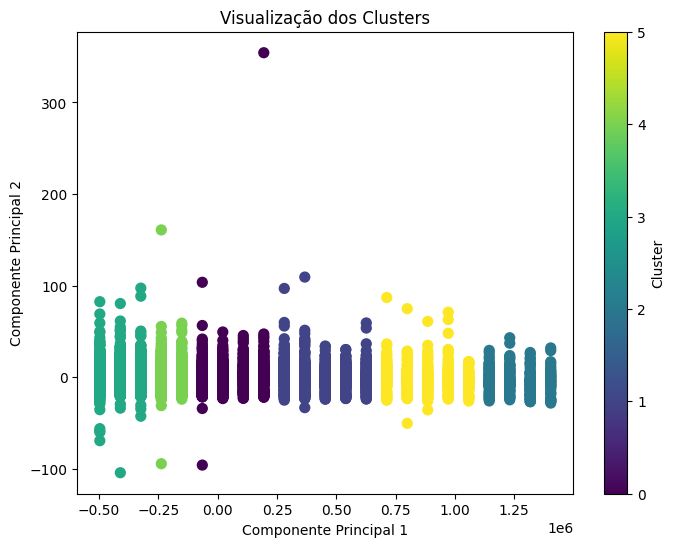

In [25]:
# 5. Visualização (usando PCA para reduzir para 2 dimensões)
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(data_silhouette)#.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df["Cluster"], cmap='viridis', s=50)
plt.title("Visualização dos Clusters")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='Cluster')
plt.show()


Score médio da Silhueta: 0.581


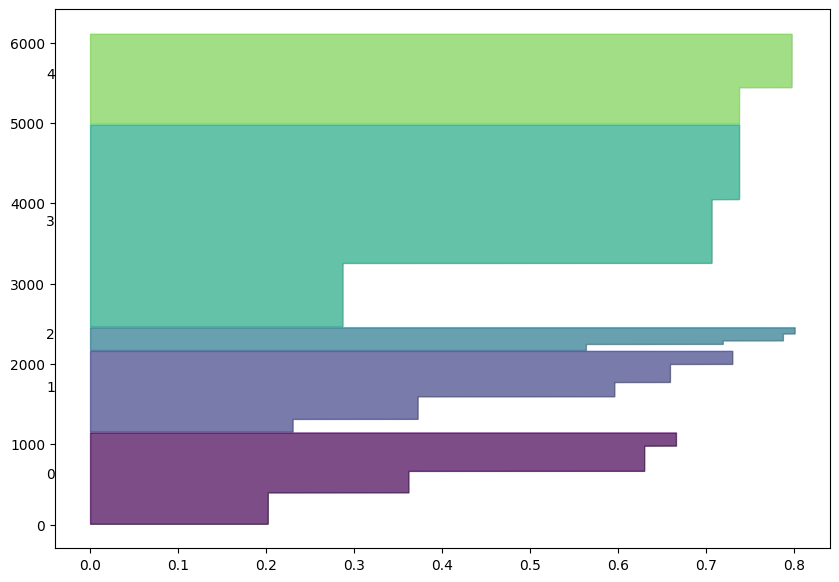

In [27]:
from sklearn.metrics import silhouette_score, silhouette_samples

# 4. Calcular o score médio da silhueta
silhouette_avg = silhouette_score(data_silhouette, kmeans.named_steps['kmeans'].labels_)
print(f"Score médio da Silhueta: {silhouette_avg:.3f}")

# 5. Calcular as pontuações de silhueta individuais
silhouette_values = silhouette_samples(data_silhouette, kmeans.named_steps['kmeans'].labels_)

# 6. Visualização das pontuações da silhueta para cada cluster
fig, ax1 = plt.subplots(1, 1, figsize=(10, 7))
y_lower = 10

for i in range(5):  # 5 clusters
    cluster_silhouette_values = silhouette_values[kmeans.named_steps['kmeans'].labels_ == i]
    cluster_silhouette_values.sort()
    size_cluster = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster
    
    color = plt.cm.viridis(float(i) / 5)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )
    ax1.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
    y_lower = y_upper + 10  # Espaço entre clusters

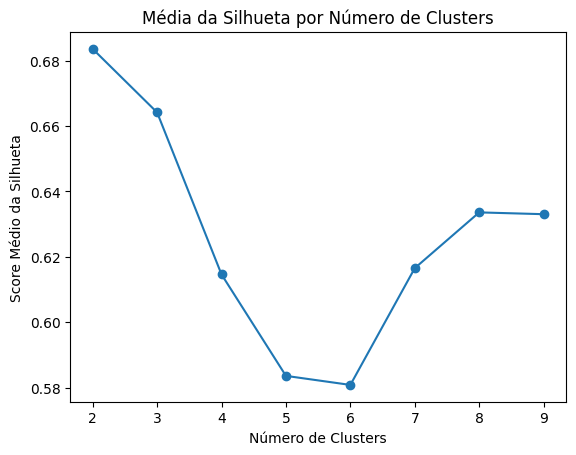

In [28]:
from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 10)
silhouette_scores = []

data_silhouette = preprocessor.fit_transform(df)

for n_clusters in range_n_clusters:
    kmeans = make_pipeline(preprocessor, KMeans(n_clusters=n_clusters, random_state=42))
    kmeans.fit(df)
    score = silhouette_score(data_silhouette, kmeans.named_steps['kmeans'].labels_)
    silhouette_scores.append(score)

import matplotlib.pyplot as plt
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Média da Silhueta por Número de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Score Médio da Silhueta")
plt.show()



In [29]:
def best_silhouette_scores(list_silhoutte):
    best_silhouette = max(list_silhoutte)
    indexes = range(len(list_silhoutte))
    print(best_silhouette)
    return list(filter(lambda i: list_silhoutte[i] == best_silhouette, indexes))


best_silhouette_scores(silhouette_scores)


0.6835954237078559


[0]

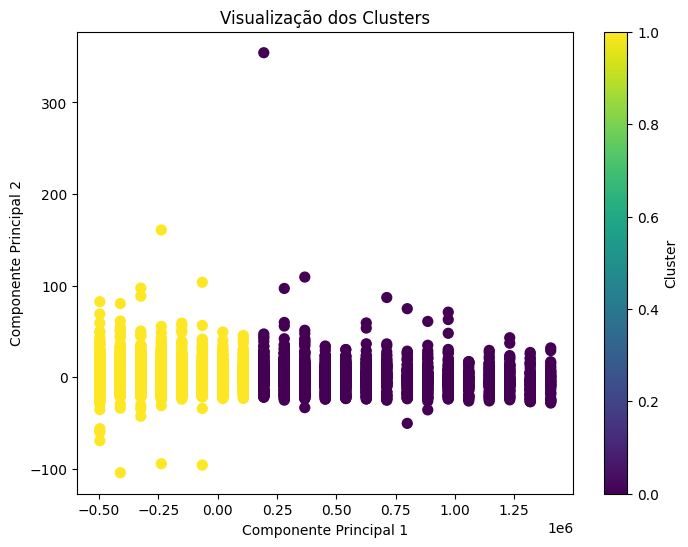

In [31]:
kmeans = make_pipeline(preprocessor, KMeans(n_clusters=2, random_state=42))
kmeans.fit(df)

# Obter os rótulos dos clusters
labels = kmeans.named_steps['kmeans'].labels_

# Adicionar os rótulos ao DataFrame original
df['Cluster'] = labels


# 5. Visualização (usando PCA para reduzir para 2 dimensões)
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(data_silhouette)#.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df["Cluster"], cmap='viridis', s=50)
plt.title("Visualização dos Clusters")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='Cluster')
plt.show()

In [32]:
data_silhouette

array([[ 1.73465280e+09, -1.81835100e-01,  5.05045354e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.73465280e+09, -1.89823613e-01,  6.89629555e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.73465280e+09, -1.61907114e-02,  4.67542380e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.73275200e+09, -2.36416578e-01,  2.48570383e-01, ...,
         2.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.73275200e+09, -1.16784871e-01,  6.57907903e-01, ...,
         3.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.73275200e+09,  2.96520203e-01,  7.62677908e-01, ...,
         7.00000000e+00,  0.00000000e+00,  1.00000000e+00]],
      shape=(6535, 391))

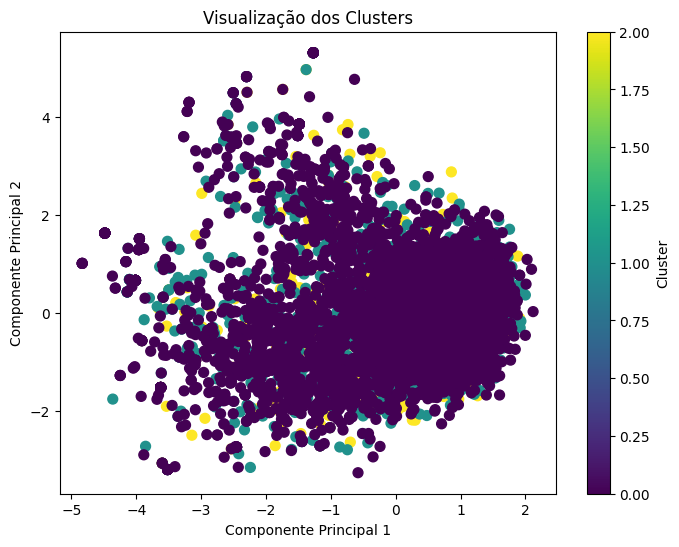

In [269]:
kmeans = make_pipeline(preprocessor, KMeans(n_clusters=3, random_state=42))
kmeans.fit(df)

# Obter os rótulos dos clusters
labels = kmeans.named_steps['kmeans'].labels_

# Adicionar os rótulos ao DataFrame original
df['Cluster'] = labels


# 5. Visualização (usando PCA para reduzir para 2 dimensões)
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X)#.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df["Cluster"], cmap='viridis', s=50)
plt.title("Visualização dos Clusters")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='Cluster')
plt.show()

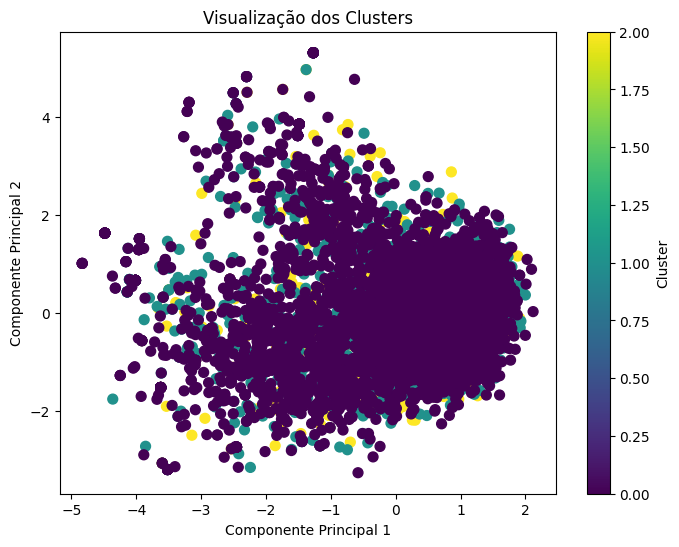

In [34]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
X = model.encode(df["texto_processado"])


kmeans = make_pipeline(preprocessor, KMeans(n_clusters=3, random_state=42))
kmeans.fit(df)

# Obter os rótulos dos clusters
labels = kmeans.named_steps['kmeans'].labels_

# Adicionar os rótulos ao DataFrame original
df['Cluster'] = labels


# 5. Visualização (usando PCA para reduzir para 2 dimensões)
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X)#.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df["Cluster"], cmap='viridis', s=50)
plt.title("Visualização dos Clusters")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='Cluster')
plt.show()

In [21]:
kmeans = make_pipeline(preprocessor, KMeans(n_clusters=3, random_state=42))
kmeans.fit(df)


# Obter os rótulos dos clusters
labels = kmeans.named_steps['kmeans'].labels_

# Adicionar os rótulos ao DataFrame original
df['Cluster'] = labels

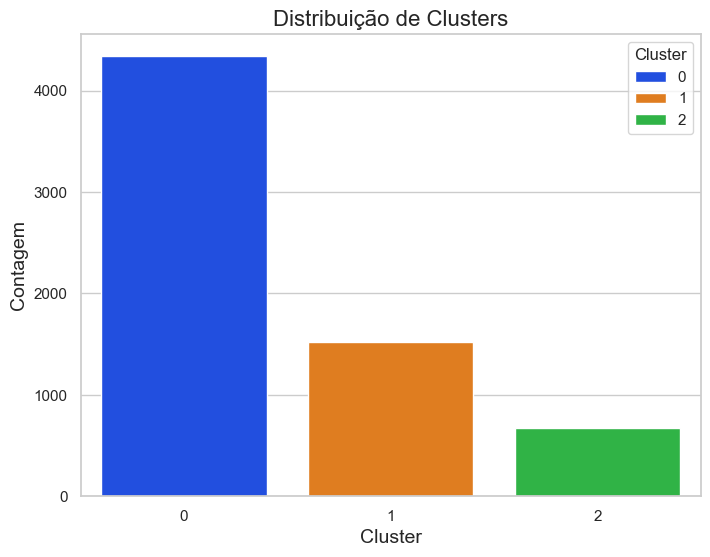

In [71]:
# Configurando o estilo do gráfico
sns.set_theme(style="whitegrid")

# Criando o gráfico de barras laterais
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="Cluster", hue="Cluster", palette="bright")
plt.title("Distribuição de Clusters", fontsize=16)
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Contagem", fontsize=14)

# Mostrando o gráfico
plt.show()

In [22]:

#Não necessariamente o cluster vai ter o mesmo valor do Label!!!!!!!!!!!!
df.loc[df['label'] == df['Cluster']]

,quantidade_premios,votos_review,avaliacao,horas_jogadas,data_publicacao,texto_processado,recebeu_gratis,review_util,review_engracado,label,Cluster
671,0,No one has rated this review as helpful yet,Recommended,20.4,2024-12-12,"Que jogo incrível, esperei quatro anos por ess...",0,0,0,1,1
672,0,No one has rated this review as helpful yet,Recommended,26.5,2024-12-12,Eu tive uma das minhas melhores experiências d...,0,0,0,1,1
673,0,No one has rated this review as helpful yet,Recommended,31.9,2024-12-12,"Simplamente valeu a pena a espera, pois o jogo...",0,0,0,1,1
674,0,No one has rated this review as helpful yet,Recommended,17.4,2024-12-12,"Que experiência! É um jogo envolvente, grafica...",0,0,0,1,1
675,0,No one has rated this review as helpful yet,Recommended,16.2,2024-12-12,O paranormal não vem para a nossa realidade de...,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
6487,2,34 people found this review helpful7 people fo...,Not Recommended,5.2,2024-11-28,A Otimização é considerada um dos problemas ma...,0,34,7,0,0
6489,0,No one has rated this review as helpful yet,Not Recommended,3.7,2024-11-28,"Tem enigma e também tem medo, mas não tem jogo...",0,0,0,0,0
6497,0,11 people found this review helpful3 people fo...,Not Recommended,31.5,2024-11-28,"Depois de 40 minutos tentando abrir, consegui ...",0,11,3,0,0
6517,0,10 people found this review helpful,Not Recommended,0.1,2024-11-28,"O jogo parece bom, mas tem uma otimização HORR...",0,10,0,0,0


In [23]:
df.loc[df['Cluster'] == 0, 'label'].value_counts()

label
1    4147
0     192
Name: count, dtype: int64

In [24]:
df.loc[df['Cluster'] == 1, 'label'].value_counts()

label
1    1495
0      30
Name: count, dtype: int64

In [25]:
df.loc[df['Cluster'] == 2, 'label'].value_counts()

label
1    659
0     12
Name: count, dtype: int64

In [26]:
class ShowReview:
    def __init__(self, quantidade_premios, horas_jogadas, data_publicacao, 
                recebeu_gratis, review_util, review_engracado, label, Cluster, texto_processado):
        self.quantidade_premios = quantidade_premios
        self.horas_jogadas = horas_jogadas
        self.data_publicacao = data_publicacao 
        self.recebeu_gratis = recebeu_gratis
        self.review_util = review_util
        self.review_engracado = review_engracado
        self.label = label
        self.Cluster = Cluster
        self.texto_processado = texto_processado

    def corpus_review(self, doc, break_line=60):
        words = doc.split(" ")
        string_faixa = ''
        corpus = ''

        for word in words:
            string_faixa += f'{word} '
            if len(string_faixa) >= break_line:
                corpus += string_faixa + '\n'
                string_faixa = ''
        return corpus


    def __str__(self):
        body = ''
        for key, value in self.__dict__.items():
            if key != 'texto_processado':
                body += f'{key:<70} {value}\n'
            else:
                body += '-' * 70 + '\n'
                body += "Texto da review:\n"
                body += '-' * 70 + '\n' 
                body += self.corpus_review(value)
                body += '-' * 70 + '\n'
        return body


In [ ]:
columns_show_review = ['quantidade_premios', 'horas_jogadas', 'data_publicacao','recebeu_gratis', 'review_util', 'review_engracado', 'label', 'Cluster', 'texto_processado']

In [36]:
cluster_0 = df.loc[df['Cluster'] == 0][:10]


for i in cluster_0.index:
    print(ShowReview(*cluster_0.loc[i, columns_show_review]),'\n')



quantidade_premios                                                     0
horas_jogadas                                                          29.8
data_publicacao                                                        2024-12-04 00:00:00
recebeu_gratis                                                         0
review_util                                                            0
review_engracado                                                       0
label                                                                  1
Cluster                                                                0
----------------------------------------------------------------------
Texto da review:
----------------------------------------------------------------------
E então o cara entrou em um servidor de Minecraft, fez um litro 
de coisas lá dentro apenas para promover o seu próprio jogo. 
----------------------------------------------------------------------
 

quantidade_premios                 

In [37]:
cluster_1 = df.loc[df['Cluster'] == 1][:10]

for i in cluster_1.index:
    print(ShowReview(*cluster_1.loc[i, columns_show_review]),'\n')

quantidade_premios                                                     0
horas_jogadas                                                          20.4
data_publicacao                                                        2024-12-12 00:00:00
recebeu_gratis                                                         0
review_util                                                            0
review_engracado                                                       0
label                                                                  1
Cluster                                                                1
----------------------------------------------------------------------
Texto da review:
----------------------------------------------------------------------
Que jogo incrível, esperei quatro anos por essa bomba, mas no 
final valeu a pena. Cada hora que eu perdi tentando resolver 
cada enigma foi maravilhosa. Bati em morto, cego e até espírito. 
(Não jogue no modo detetive caso tenha um QI 

In [38]:
cluster_2 = df.loc[df['Cluster'] == 2][:10]

for i in cluster_2.index:
    print(ShowReview(*cluster_2.loc[i, columns_show_review]),'\n')


quantidade_premios                                                     0
horas_jogadas                                                          37.4
data_publicacao                                                        2024-12-20 00:00:00
recebeu_gratis                                                         0
review_util                                                            0
review_engracado                                                       0
label                                                                  1
Cluster                                                                2
----------------------------------------------------------------------
Texto da review:
----------------------------------------------------------------------
A investigação é incrível e a história é absurda da boa, eu 
recomendo muito que todos experimentem essa história. Mas infelizmente 
nem tudo pode ser perfeito, e para mim a gameplay foi algo que 
pecou bastante ao longo da jogatina, os

## Revisar

In [202]:
from sklearn.cluster import DBSCAN

dbscan = make_pipeline(preprocessor,DBSCAN(eps=0.65, min_samples=5, metric='cosine'))  # Configurações importantes
dbscan.fit_predict(df)

array([0, 0, 0, ..., 0, 0, 0], shape=(6535,))

Score médio da Silhueta: -0.008


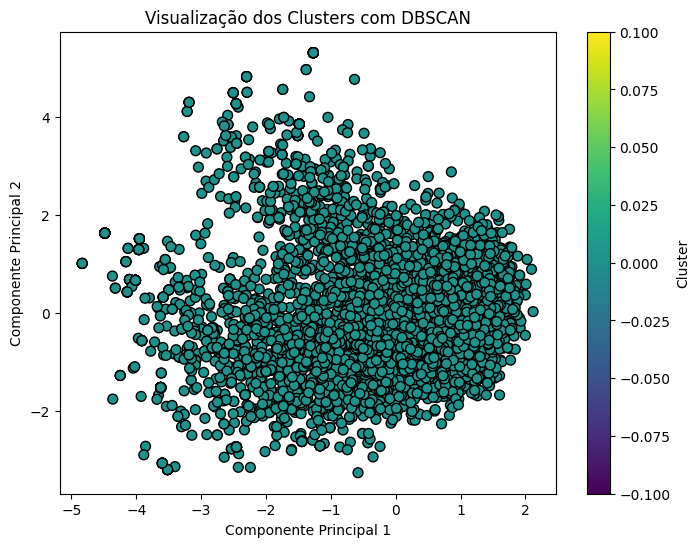

In [203]:


# Adicionar os rótulos ao DataFrame
df["Cluster"] = dbscan.named_steps['dbscan'].labels_

# 4. Avaliar os resultados
# Calcular o score médio da silhueta (exclui os pontos ruidosos - cluster -1)
if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X, labels, metric='cosine')
    print(f"Score médio da Silhueta: {silhouette_avg:.3f}")
else:
    print("Não foi possível calcular o score da silhueta (apenas um cluster ou todos são ruídos).")

# 5. Visualizar os clusters usando PCA
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X)#.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=df["Cluster"],
    cmap='viridis',
    s=50,
    edgecolor='k'
)
plt.title("Visualização dos Clusters com DBSCAN")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='Cluster')
plt.show()


In [80]:
# 2. Vetorização dos textos
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
X = model.encode(df["texto_processado"])


In [75]:


# 3. Aplicar K-Means com 5 clusters
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(X)

# 4. Adicionar os clusters ao DataFrame
df["Cluster"] = kmeans.labels_



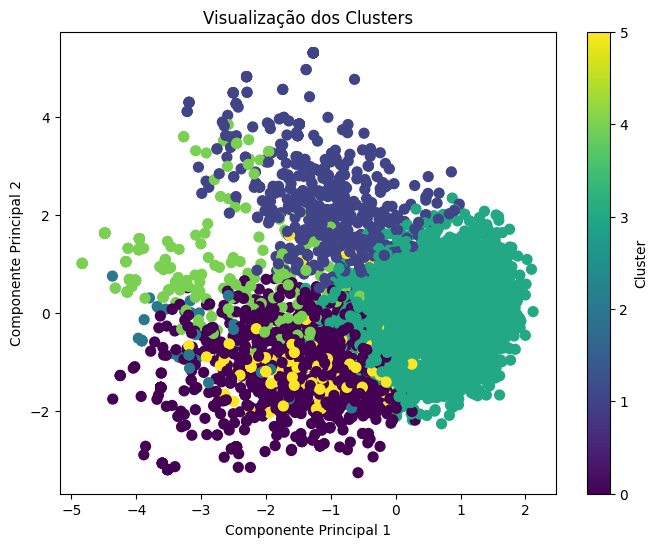

In [76]:
# 5. Visualização (usando PCA para reduzir para 2 dimensões)
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X)#.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df["Cluster"], cmap='viridis', s=50)
plt.title("Visualização dos Clusters")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='Cluster')
plt.show()


Score médio da Silhueta: 0.184


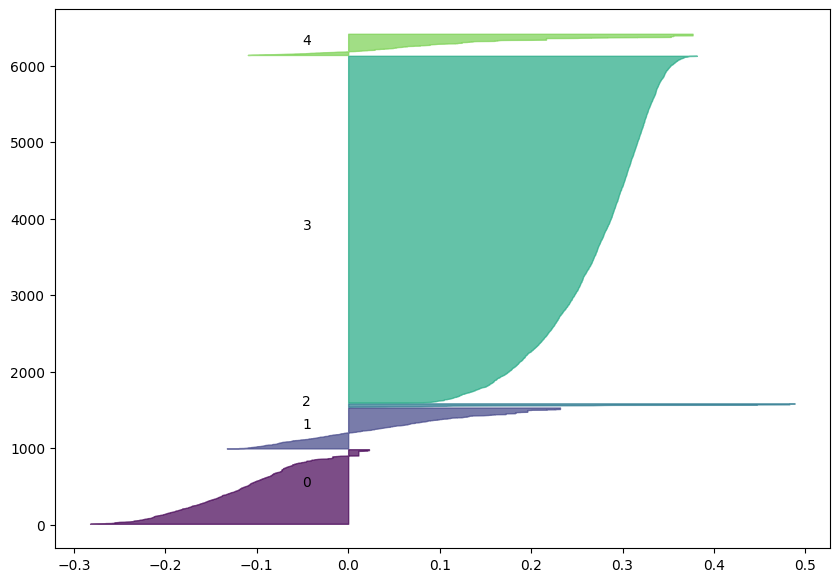

In [77]:
from sklearn.metrics import silhouette_score, silhouette_samples

# 4. Calcular o score médio da silhueta
silhouette_avg = silhouette_score(X, kmeans.labels_)
print(f"Score médio da Silhueta: {silhouette_avg:.3f}")

# 5. Calcular as pontuações de silhueta individuais
silhouette_values = silhouette_samples(X, kmeans.labels_)

# 6. Visualização das pontuações da silhueta para cada cluster
fig, ax1 = plt.subplots(1, 1, figsize=(10, 7))
y_lower = 10

for i in range(5):  # 5 clusters
    cluster_silhouette_values = silhouette_values[kmeans.labels_ == i]
    cluster_silhouette_values.sort()
    size_cluster = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster
    
    color = plt.cm.viridis(float(i) / 5)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )
    ax1.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
    y_lower = y_upper + 10  # Espaço entre clusters

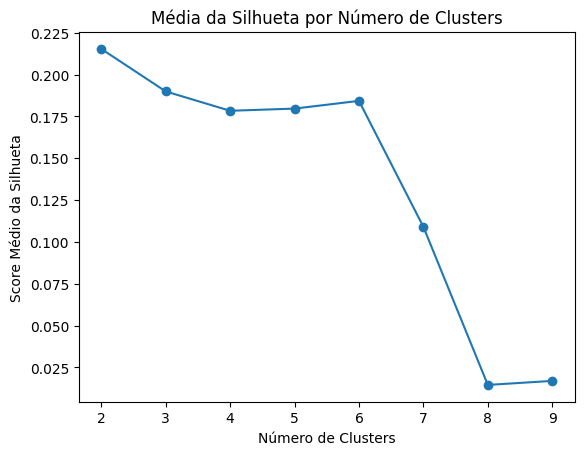

In [78]:
from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 10)
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

import matplotlib.pyplot as plt
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Média da Silhueta por Número de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Score Médio da Silhueta")
plt.show()

Score médio da Silhueta: 0.332


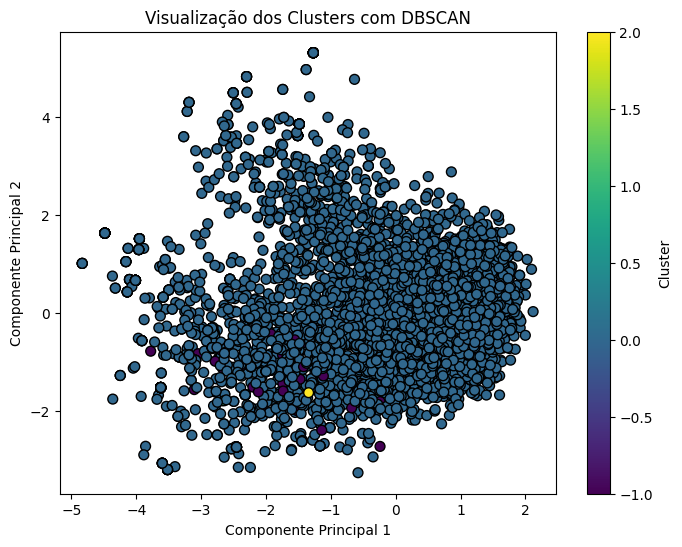

In [79]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=2, metric='cosine')  # Configurações importantes
labels = dbscan.fit_predict(X)

# Adicionar os rótulos ao DataFrame
df["Cluster"] = labels

# 4. Avaliar os resultados
# Calcular o score médio da silhueta (exclui os pontos ruidosos - cluster -1)
if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X, labels, metric='cosine')
    print(f"Score médio da Silhueta: {silhouette_avg:.3f}")
else:
    print("Não foi possível calcular o score da silhueta (apenas um cluster ou todos são ruídos).")

# 5. Visualizar os clusters usando PCA
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X)#.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=df["Cluster"],
    cmap='viridis',
    s=50,
    edgecolor='k'
)
plt.title("Visualização dos Clusters com DBSCAN")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='Cluster')
plt.show()


In [29]:
df

,premios_review,quantidade_premios,votos_review,avaliacao,horas_jogadas,recebeu_gratis,data_publicacao,texto_review,texto_processado,Cluster
0,[],0,No one has rated this review as helpful yet,Recommended,37.4 hrs on record,No received,Posted: 20 December,A investigação é INCRÍVEL e a história é ABSUR...,A investigação é incrível e a história é absur...,-1
1,[],0,No one has rated this review as helpful yet,Recommended,21.0 hrs on record,No received,Posted: 20 December,eu esperei por muito tempo pra jogar esse jogo...,Eu aguardei por muito tempo para jogar esse jo...,-1
2,[],0,No one has rated this review as helpful yet,Recommended,5.1 hrs on record,No received,Posted: 20 December,"gosto da ambientação, enigmas e personagens, a...","Gosto da ambientação, enigmas e personagens, a...",-1
3,[],0,No one has rated this review as helpful yet,Recommended,3.3 hrs on record,No received,Posted: 20 December,"compatibilidade péssima, mas...ordem paranorma...","Compatibilidade péssima, mas... ordem paranorm...",0
4,[],0,No one has rated this review as helpful yet,Recommended,34.1 hrs on record,No received,Posted: 20 December,"A estética do jogo é simplesmente incrível, co...","A estética do jogo é simplesmente incrível, co...",-1
...,...,...,...,...,...,...,...,...,...,...
6530,[],0,5 people found this review helpful,Recommended,0.3 hrs on record,No received,Posted: November 28,jogo do selbit,Jogo do Selvagem. O Jogo do Selvagem (ou Selva...,-1
6531,[],0,13 people found this review helpful7 people fo...,Recommended,3.0 hrs on record,No received,Posted: November 28,"Esse jogo é bom demais, simplesmente peak. (pr...",Esse jogo é tão bom que não consigo deixar de ...,-1
6532,[],0,2 people found this review helpful,Recommended,40.7 hrs on record,No received,Posted: November 28,"bom, vamos lá, irei fazer uma analise bem comp...",Enigma do Medo é um jogo incrível e eu recomen...,-1
6533,[],0,3 people found this review helpful,Recommended,33.9 hrs on record,No received,Posted: November 28,goty 2025,Os Melhores Jogos de 2025: uma previsão,-1
